# Exploratory Data Analysis (EDA) for the Amazon Customer Reviews Dataset

In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


## Data Loading (Amazon Reviews Dataset 2023)
The dataset is loaded from the Hugging Face datasets library.

In [3]:
# Select 3 categories to highlight cross-domain transfer
TARGET_DOMAINS = ["Books", "Movies_and_TV", "Video_Games"]
MIN_USER_INTERACTIONS = 5
MIN_ITEM_INTERACTIONS = 5
POSITIVE_THRESHOLD = 4.0  # Ratings >= 4.0 are considered positive

# Load the dataset
def load_amazon_reviews(domain:str, max_per_domain:int=100000) -> pd.DataFrame:
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023",
                           f"raw_review_{domain}",
                           trust_remote_code=True)
    rows = []
    for i, r in enumerate(dataset["full"]):
        if i >= max_per_domain:
            break
        rows.append({
            "user": r["user_id"],
            "item": r["parent_asin"],
            "rating": float(r["rating"]),
            "title": r.get("title", ""),
            "text": r.get("text", ""),
            "domain": domain,
            "timestamp": int(r["timestamp"])
        })
    return pd.DataFrame(rows)

dfs = [load_amazon_reviews(dom, max_per_domain=100000) for dom in TARGET_DOMAINS]
df = pd.concat(dfs, ignore_index=True).sort_values("timestamp").reset_index(drop=True)

Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

## Exploratory Data Analysis (EDA)
This section provides an overview of the dataset, including basic statistics, domain analysis, rating distribution, user behavior, item analysis, and cross-domain patterns.

#### Basic data overview:

In [4]:
# Basic data overview
print("Dataset shape:", df.shape)
print("Columns information:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

print("\nMissing percentage:")
print(df.isnull().mean() * 100)

print("\nUnique users:", df["user"].nunique())
print("Unique items:", df["item"].nunique())
print("Unique domains:", df["domain"].nunique())
print("Unique ratings:", df["rating"].nunique())

Dataset shape: (300000, 7)
Columns information:
user          object
item          object
rating       float64
title         object
text          object
domain        object
timestamp      int64
dtype: object

Basic statistics:
              rating     timestamp
count  300000.000000  3.000000e+05
mean        4.270713  1.481078e+12
std         1.161590  1.255758e+11
min         1.000000  8.715715e+11
25%         4.000000  1.417550e+12
50%         5.000000  1.484965e+12
75%         5.000000  1.575745e+12
max         5.000000  1.679235e+12

Missing values:
user         0
item         0
rating       0
title        0
text         0
domain       0
timestamp    0
dtype: int64

Missing percentage:
user         0.0
item         0.0
rating       0.0
title        0.0
text         0.0
domain       0.0
timestamp    0.0
dtype: float64

Unique users: 57515
Unique items: 164247
Unique domains: 3
Unique ratings: 5


#### Domain analysis:

Reviews per domain:
domain
Books            100000
Movies_and_TV    100000
Video_Games      100000
Name: count, dtype: int64


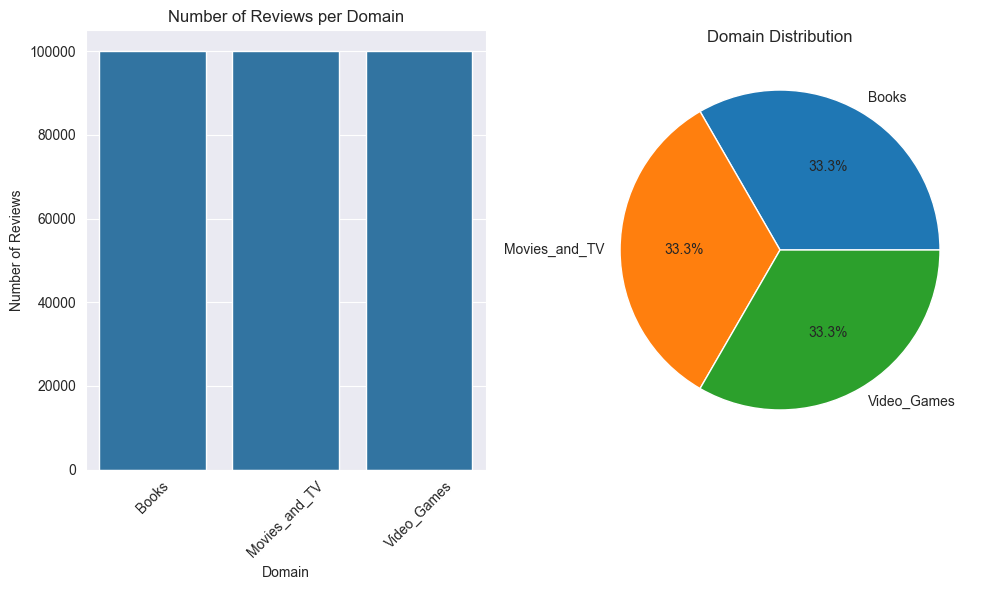

In [5]:
domain_counts = df["domain"].value_counts()
print("Reviews per domain:")
print(domain_counts)

# Visualize domain distribution
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=domain_counts.index, y=domain_counts.values)
plt.title("Number of Reviews per Domain")
plt.xlabel("Domain")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(domain_counts.values, labels=domain_counts.index, autopct='%1.1f%%')
plt.title("Domain Distribution")

plt.tight_layout()
plt.show()

#### Rating analysis:

Overall rating distribution:
rating
1.0     17846
2.0     12989
3.0     26736
4.0     54963
5.0    187466
Name: count, dtype: int64
Rating statistics:
Mean rating: 4.27
Median rating: 5.00
Standard deviation: 1.16


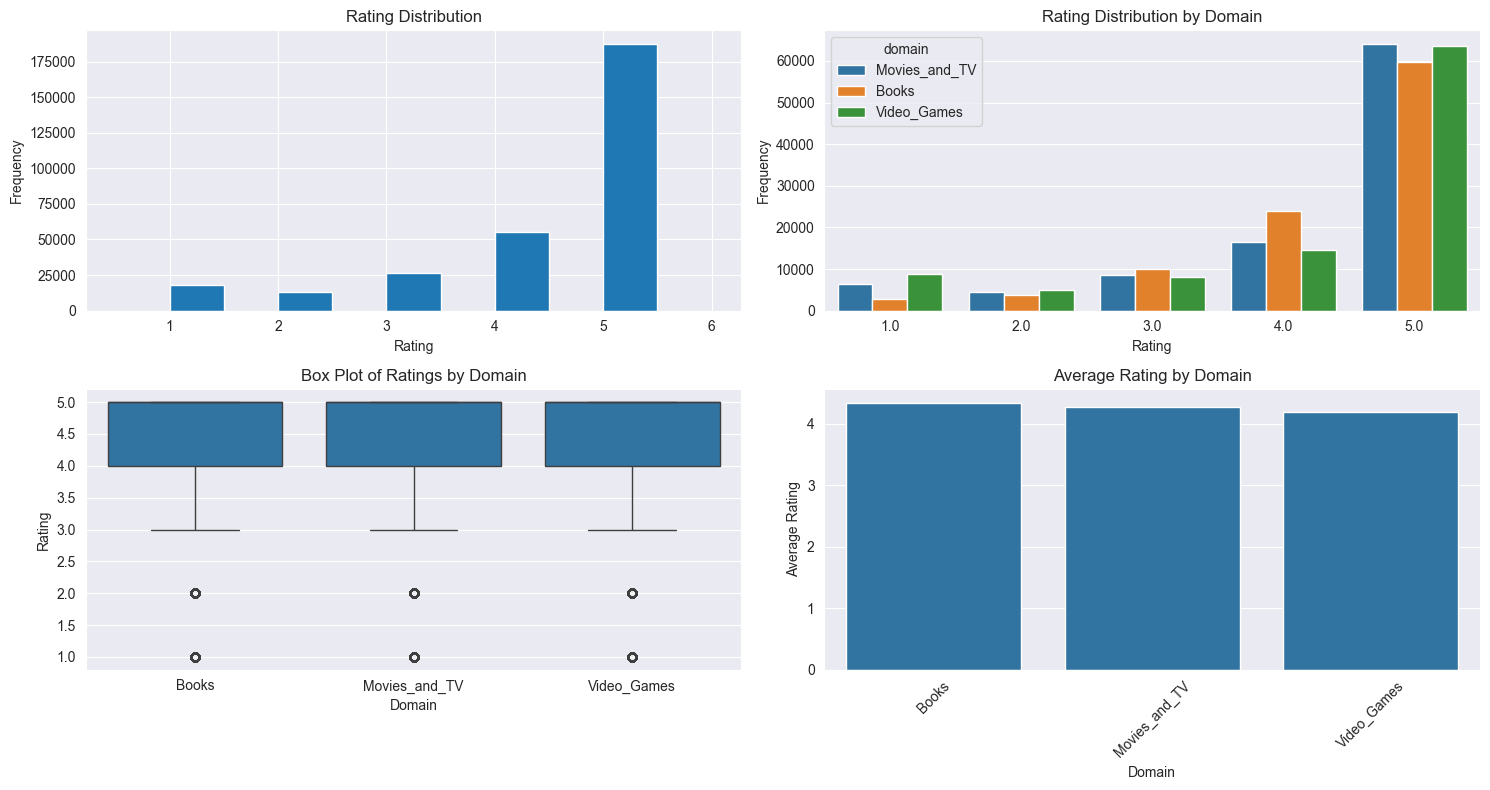

In [6]:
rating_counts = df["rating"].value_counts().sort_index()
print("Overall rating distribution:")
print(rating_counts)

# Rating statistics
print("Rating statistics:")
print(f"Mean rating: {df['rating'].mean():.2f}")
print(f"Median rating: {df['rating'].median():.2f}")
print(f"Standard deviation: {df['rating'].std():.2f}")

# Visualize rating distribution
plt.figure(figsize=(15, 8))

# Overall rating distribution
plt.subplot(2, 2, 1)
plt.hist(df["rating"], bins=np.arange(0.5, 6.5, 0.5))
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")

# Rating distribution by domain
plt.subplot(2, 2, 2)
sns.countplot(df, x="rating", hue="domain")
plt.title("Rating Distribution by Domain")
plt.xlabel("Rating")
plt.ylabel("Frequency")

# Box plot of ratings by domain
plt.subplot(2, 2, 3)
sns.boxplot(df, x="domain", y="rating")
plt.title("Box Plot of Ratings by Domain")
plt.xlabel("Domain")
plt.ylabel("Rating")

# Average rating by domain
plt.subplot(2, 2, 4)
sns.barplot(x=domain_counts.index, y=df.groupby("domain")["rating"].mean().sort_values(ascending=False))
plt.title("Average Rating by Domain")
plt.xlabel("Domain")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### User behavior analysis:

User Activity Statistics:
Average reviews per user: 5.22
Median reviews per user: 2.00
Max reviews by single user: 3940
Users with multiple reviews: 11677 (20.3%)
Users active in multiple domains: 7871 (13.7%)


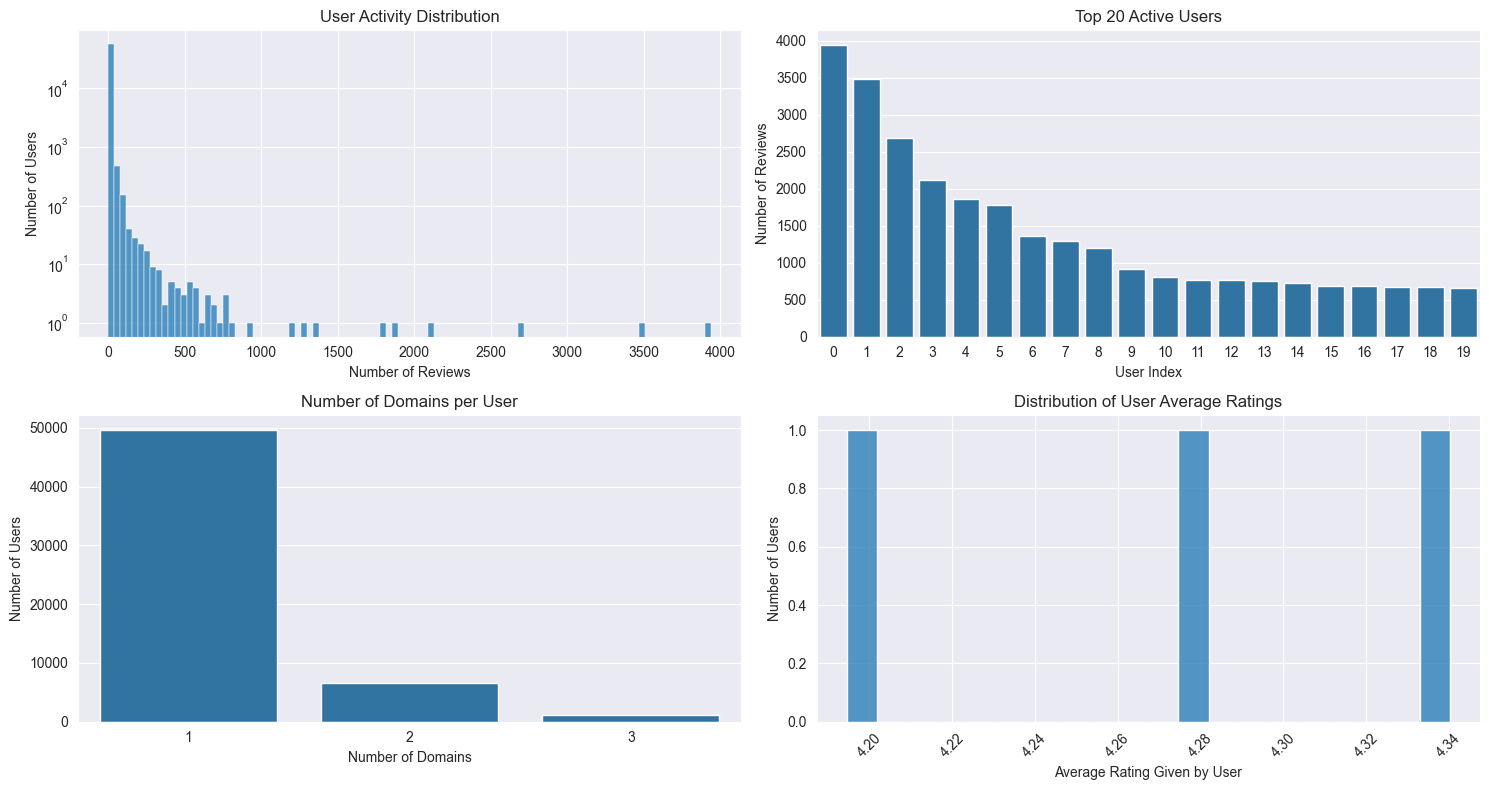

In [7]:
# User activity analysis
user_activity = df["user"].value_counts()

print("User Activity Statistics:")
print(f"Average reviews per user: {user_activity.mean():.2f}")
print(f"Median reviews per user: {user_activity.median():.2f}")
print(f"Max reviews by single user: {user_activity.max()}")

# Users with reviews more than equal to 5
multi_review_users = user_activity[user_activity >= 5]
print(f"Users with multiple reviews: {len(multi_review_users)} ({len(multi_review_users)/len(user_activity)*100:.1f}%)")

# Cross-domain user analysis
user_domains = df.groupby("user")["domain"].nunique()
cross_domain_users = user_domains[user_domains > 1]
print(f"Users active in multiple domains: {len(cross_domain_users)} ({len(cross_domain_users)/len(user_domains)*100:.1f}%)")

# Visualize user activity
plt.figure(figsize=(15, 8))

# User activity distribution
plt.subplot(2, 2, 1)
sns.histplot(user_activity, bins=100)
plt.title("User Activity Distribution")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")
plt.yscale("log")

# Top active users
plt.subplot(2, 2, 2)
top_users = user_activity.head(20)
sns.barplot(x=range(len(top_users)), y=top_users.values)
plt.title("Top 20 Active Users")
plt.xlabel("User Index")
plt.ylabel("Number of Reviews")

# Cross-domain user distribution
plt.subplot(2, 2, 3)
cross_domain_counts = user_domains.value_counts().sort_index()
sns.barplot(x=cross_domain_counts.index, y=cross_domain_counts.values)
plt.title("Number of Domains per User")
plt.xlabel("Number of Domains")
plt.ylabel("Number of Users")

# User rating behavior
plt.subplot(2, 2, 4)
sns.histplot(df.groupby("domain")["rating"].mean(), bins=20)
plt.title("Distribution of User Average Ratings")
plt.xlabel("Average Rating Given by User")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Item analysis:

Item Popularity Statistics:
Average reviews per item: 1.83
Median reviews per item: 1.00
Max reviews for a single item: 764
Popular items (5 or more reviews): 7817 (4.8%)

Item Rating Statistics:
Average rating per item: 4.27
Median rating per item: 5.00
Items with perfect ratings (5.0): 87899


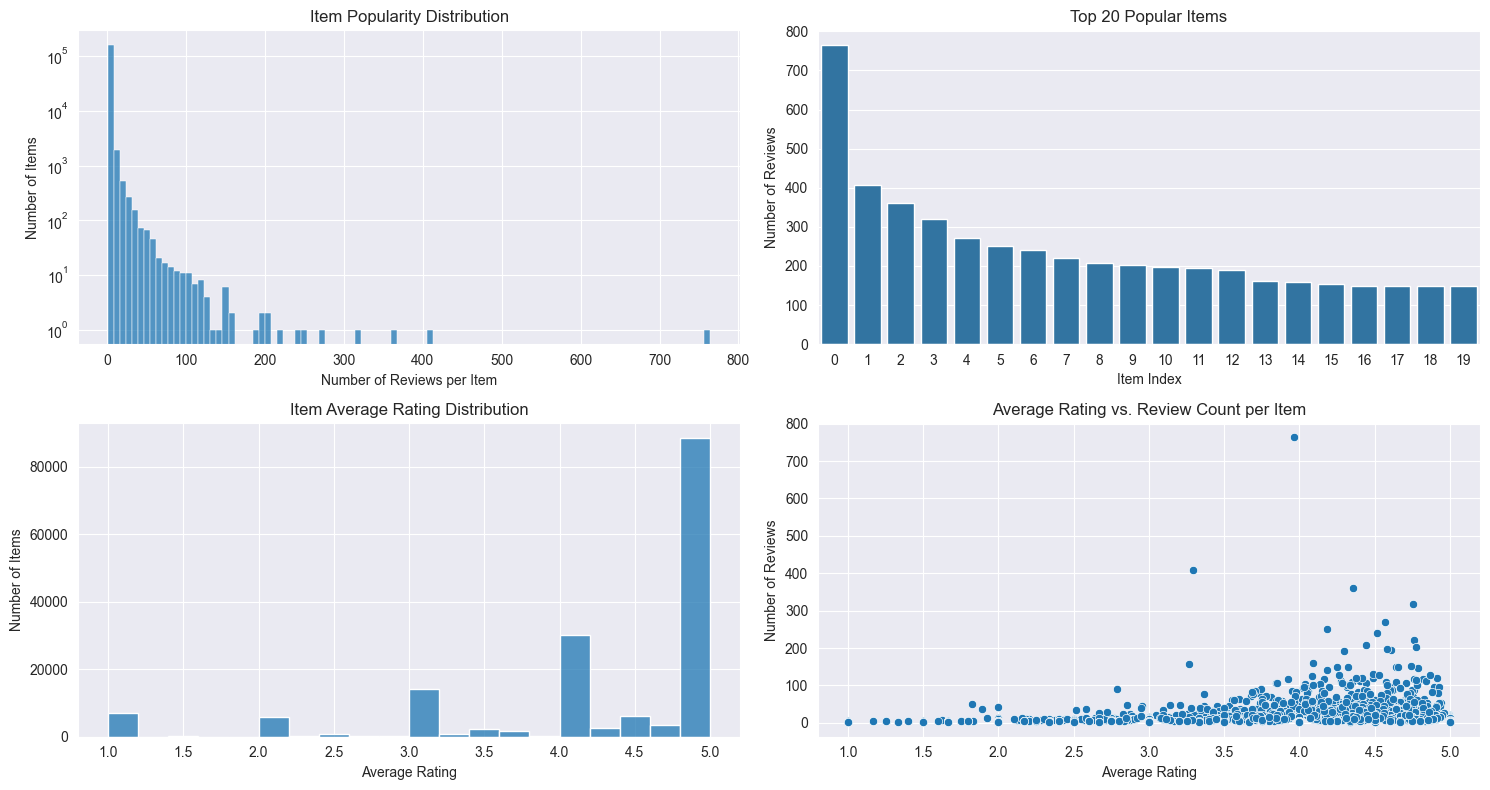

In [8]:
# Item popularity analysis
item_popularity = df["item"].value_counts()

print("Item Popularity Statistics:")
print(f"Average reviews per item: {item_popularity.mean():.2f}")
print(f"Median reviews per item: {item_popularity.median():.2f}")
print(f"Max reviews for a single item: {item_popularity.max()}")

# Popular items
popular_items = item_popularity[item_popularity >= 5]
print("Popular items (5 or more reviews):", len(popular_items), f"({len(popular_items)/len(item_popularity)*100:.1f}%)")

# Item rating analysis
item_avg_ratings = df.groupby("item")["rating"].agg(["mean", "count", "std"]).reset_index()
item_avg_ratings.columns = ["item", "avg_rating", "review_count", "rating_std"]

print("\nItem Rating Statistics:")
print(f"Average rating per item: {item_avg_ratings['avg_rating'].mean():.2f}")
print(f"Median rating per item: {item_avg_ratings['avg_rating'].median():.2f}")
print(f"Items with perfect ratings (5.0): {item_avg_ratings[item_avg_ratings['avg_rating'] == 5.0].shape[0]}")

# Visualize item analysis
plt.figure(figsize=(15, 8))

# Item popularity distribution
plt.subplot(2, 2, 1)
sns.histplot(item_popularity.values, bins=100)
plt.title("Item Popularity Distribution")
plt.xlabel("Number of Reviews per Item")
plt.ylabel("Number of Items")
plt.yscale("log")

# Top popular items
plt.subplot(2, 2, 2)
top_items = item_popularity.head(20)
sns.barplot(x=range(len(top_items)), y=top_items.values)
plt.title("Top 20 Popular Items")
plt.xlabel("Item Index")
plt.ylabel("Number of Reviews")

# Item average rating distribution
plt.subplot(2, 2, 3)
sns.histplot(item_avg_ratings["avg_rating"], bins=20)
plt.title("Item Average Rating Distribution")
plt.xlabel("Average Rating")
plt.ylabel("Number of Items")

# Rating vs popularity correlation
plt.subplot(2, 2, 4)
sns.scatterplot(x=item_avg_ratings["avg_rating"], y=item_avg_ratings["review_count"])
plt.title("Average Rating vs. Review Count per Item")
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")

plt.tight_layout()
plt.show()

#### Cross-domain patterns:

In [9]:
# Cross-domain user behavior matrix
cross_domain_matrix = pd.crosstab(df["user"], df["domain"])
cross_domain_binary = (cross_domain_matrix > 0).astype(int)

domain_combinations = {}

for i, domain1 in enumerate(df["domain"].unique()):
    for j, domain2 in enumerate(df["domain"].unique()):
        if i < j: # Avoid double counting
            users_in_both = ((cross_domain_binary[domain1] == 1) & (cross_domain_binary[domain2] == 1)).sum()
            total_users_domain1 = (cross_domain_binary[domain1] == 1).sum()

            if total_users_domain1 > 0:
                overlap_pct = (users_in_both / total_users_domain1) * 100
                domain_combinations[(domain1, domain2)] = {
                    "overlap_count": users_in_both,
                    "overlap_percentage": overlap_pct
                }

print("Cross-domain user overlap:")
for combo, stats in domain_combinations.items():
    print(f"{combo[0]} & {combo[1]}: {stats['overlap_count']} users ({stats['overlap_percentage']:.2f}%)")

Cross-domain user overlap:
Books & Movies_and_TV: 4700 users (47.22%)
Books & Video_Games: 1852 users (18.61%)
Movies_and_TV & Video_Games: 3737 users (21.71%)


## Filtering dataset
* Remove low ratings: We consider ratings >= 4.0 as positive.
* Remove exact duplicates: Ensure that each user-item interaction is unique.
* Reduce item sparsity: Ensure that every remaining item has at least a certain number of interactions.
* Reduce user sparsity: Ensure that every user has at least a certain number of interactions.

In [11]:
def filter_dataset(dataframe, min_user_interactions=5, min_item_interactions=5, positive_threshold=4.0):
    """Filter the dataset based on user and item interactions, and positive ratings."""
    # Remove low ratings
    dataframe["label"] = (dataframe["rating"] >= positive_threshold).astype(int)

    # Remove exact duplicates
    dataframe = dataframe.drop_duplicates()
    print(f"Dataframe before removing exact duplicates: {len(dataframe)}")
    dataframe = dataframe.drop_duplicates()
    print(f"Dataframe before interactions filtering: {len(dataframe)}")

    # Filter users and items with minimum interactions
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index

    # Filter the DataFrame
    df_filtered = dataframe[dataframe["user"].isin(valid_users) & dataframe["item"].isin(valid_items)]
    print(f"Dataframe after interactions filtering: {len(dataframe)}")

    return df_filtered

df_filtered = filter_dataset(df, MIN_USER_INTERACTIONS, MIN_ITEM_INTERACTIONS, POSITIVE_THRESHOLD)
df_filtered.sample(5)

Dataframe before removing exact duplicates: 56132
Dataframe before interactions filtering: 56132
Dataframe after interactions filtering: 56132


,user,item,rating,title,text,domain,timestamp,label
96811,AEAGNOFUPMZ5Z4MGR2WVECAXT7VA,B0064MPXFA,5.0,Addictive and excellent!,Addictive.,Movies_and_TV,1438278595000,1
234298,AHIS7E5LHRIZLQGC24RETAVKZJYQ,B004A8ZWVK,5.0,And somethings are still the same .......,This movie was wonderfully done with expert ac...,Movies_and_TV,1584904547218,1
69418,AHGSUXT56Q3XVYD6J3YBZMBOCXHA,B001TODCII,5.0,Another great Liam Neeson movie,Good Movie.... I like Liam Neeson and this mov...,Movies_and_TV,1411229265000,1
237158,AH665SQ6SQF6DXAGYIQFCX76LALA,B07VT32KBP,4.0,Love the Rainbow Lights,This is a great mechanical keyboard. it is res...,Video_Games,1588537225263,1
147754,AF2XR7EINEUZGSUJNX5I7TITZ56Q,B01I2BH290,5.0,Five Stars,Simply wonderful! This man and his wife are am...,Movies_and_TV,1483641628000,1


## Prepare the final dataset

In [12]:
# Encode user, item, and domain
def encode_columns(dataframe):
    """Encode user, item, and domain columns to integers."""
    dataframe["user_id"] = dataframe["user"].astype("category").cat.codes
    dataframe["item_id"] = dataframe["item"].astype("category").cat.codes
    dataframe["domain_id"] = dataframe["domain"].astype("category").cat.codes

    return dataframe

df_encoded = encode_columns(df_filtered)

In [25]:
# Save the final dataset to a CSV file
output_dir = "data/amazon_reviews_2023"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "amazon_reviews_2023_filtered.csv")
df_encoded.to_csv(output_file, index=False)
print(f"Filtered dataset saved to {output_file}")

Filtered dataset saved to data/amazon_reviews_2023\amazon_reviews_2023_filtered.csv
